In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize
from utils import *

In [3]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: tiwari_extranet_frfr, Model: WDSSV5, Device: cuda
Model path: out\tiwari_extranet_frfr-WDSSV5\model
Log path: out\tiwari_extranet_frfr-WDSSV5\logs


In [4]:
from network.dataset import *

train_dataset, val_dataset, test_dataset = WDSSDatasetCompressed.get_datasets(settings)
print("Test dataset size: ", len(test_dataset))

Test dataset size:  240


In [5]:
from network.models.WDSS import get_wdss_model
    
# Model
model = get_wdss_model(settings.model_config).to(device)

In [6]:
from network.losses import CriterionSSIM_L1, CriterionSSIM_MSE

criterion = CriterionSSIM_MSE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [7]:
from network.trainer import Trainer

trainer = Trainer(settings, model, optimizer, scheduler, criterion, train_dataset, val_dataset, test_dataset)

In [8]:
try:
    trainer.load_checkpoint("101.pth")
    # trainer.load_latest_checkpoint()
    print(f"Checkpoint loaded epoch: {trainer.total_epochs}")
except:
    print("No checkpoint found")

Checkpoint loaded epoch: 101


In [9]:
video_out_dir = "out/video"

# Create output directory
os.makedirs(video_out_dir, exist_ok=True)
os.makedirs(video_out_dir + "/lr", exist_ok=True)
os.makedirs(video_out_dir + "/hr", exist_ok=True)
os.makedirs(video_out_dir + "/res", exist_ok=True)

In [11]:
from tqdm import tqdm

trainer.model.eval()

for frame_no in tqdm(range(1, 120)):
    raw_frames = test_dataset[frame_no]
    log_frames = test_dataset.get_log_frames(frame_no)
    lr = raw_frames['LR'].to(device).unsqueeze(0)
    gb = raw_frames['GB'].to(device).unsqueeze(0)
    temp = raw_frames['TEMPORAL'].to(device).unsqueeze(0)
    hr = raw_frames['HR'].to(device).unsqueeze(0)
    inference = raw_frames['INFERENCE']
    for key in inference.keys():
        inference[key] = inference[key].to(device).unsqueeze(0)

    with torch.no_grad():
        wavelet, image = trainer.model.forward(lr, gb, temp, 2.0)

    lr = log_frames['LR'].to(device).unsqueeze(0)
    image, _ = test_dataset.preprocessor.postprocess(image, inference)
    hr = log_frames['HR'].to(device).unsqueeze(0)

    pos = inference['BRDF_HR'] == 0
    image[pos] = hr[pos]

    # Store the output images
    res_cv = ImageUtils.tensor_to_opencv_image(image.detach().cpu().clamp(0, 1))
    res_cv = (res_cv * 255).astype(np.uint8)
    res_cv = res_cv[..., [2, 1, 0]]  # Swap red and blue channels
    cv2.imwrite(f"{video_out_dir}/res/frame_{frame_no:04d}.png", res_cv)
    
    hr_cv = ImageUtils.tensor_to_opencv_image(hr.detach().cpu().clamp(0, 1))
    hr_cv = (hr_cv * 255).astype(np.uint8)
    hr_cv = hr_cv[..., [2, 1, 0]]  # Swap red and blue channels
    cv2.imwrite(f"{video_out_dir}/hr/frame_{frame_no:04d}.png", hr_cv)

    # LR frame
    lr_cv = ImageUtils.tensor_to_opencv_image(lr.detach().cpu().clamp(0, 1))
    lr_cv = (lr_cv * 255).astype(np.uint8)
    lr_cv = lr_cv[..., [2, 1, 0]]  # Swap red and blue channels
    cv2.imwrite(f"{video_out_dir}/lr/frame_{frame_no:04d}.png", lr_cv)

100%|██████████| 119/119 [06:18<00:00,  3.18s/it]


In [13]:
# # Load the output images and create a video
import cv2
import os

image_folder = f"{video_out_dir}/res"
video_name = f"{video_out_dir}/our_asian_video.mp4"

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 24, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()


In [13]:
exp_normalizer = BaseImageNormalizer.from_config({"type": "exponential"})

tensor(26.2711, device='cuda:0') tensor(0., device='cuda:0')
tensor(51.4045, device='cuda:0') tensor(-3.9798, device='cuda:0')


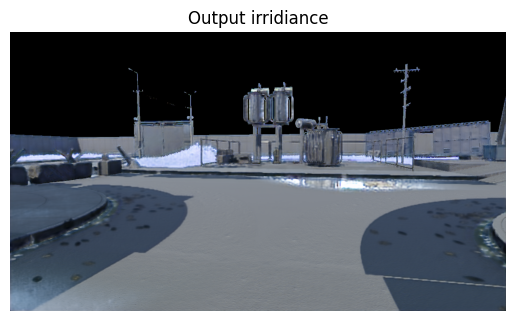

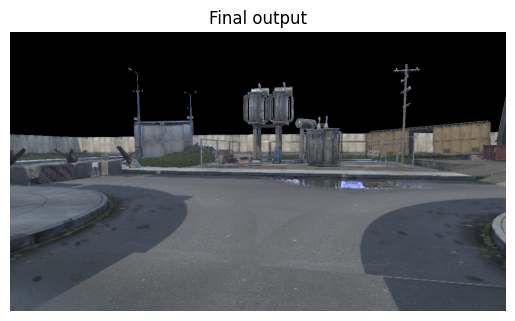

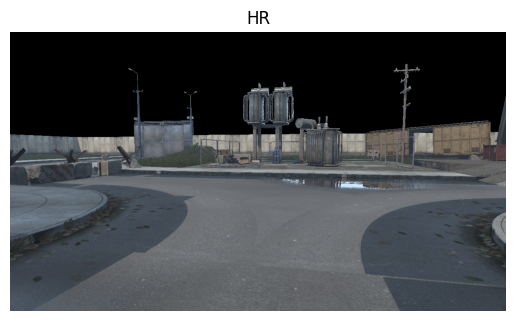

In [14]:
frame_no = 120
frame = test_dataset.get_inference_frame(frame_no)
log_frames = test_dataset.get_log_frames(frame_no)

lr = frame['LR'].to(device).unsqueeze(0)
gb = frame['GB'].to(device).unsqueeze(0)
temp = frame['TEMPORAL'].to(device).unsqueeze(0)
hr = frame['HR'].to(device).unsqueeze(0)
inference = frame['INFERENCE']

with torch.no_grad():
    wavelet, image = model.forward(lr, gb, temp, 2.0)

print(image.max(), image.min())
print(wavelet.max(), wavelet.min())

image = image.clamp(min=0, max=None)
ImageUtils.display_image(exp_normalizer.normalize(image).detach().cpu(), "Output irridiance")


# Postprocess
final, frames = test_dataset.preprocessor.postprocess(image, inference)
hr, _ = test_dataset.preprocessor.postprocess(hr, inference)

ImageUtils.display_image(final.detach().cpu(), "Final output")
ImageUtils.display_image(hr.detach().cpu(), "HR")


In [20]:
# Compute average losses
from network.losses import ImageEvaluator

total_ssim = 0.0
total_mse = 0.0
total_l1 = 0.0
total_psnr = 0.0
total_lpips = 0.0

total_ssim_bilinear = 0.0
total_mse_bilinear = 0.0
total_l1_bilinear = 0.0
total_psnr_bilinear = 0.0
total_lpips_bilinear = 0.0

In [21]:
from utils.wavelet import WaveletProcessor
from tqdm import tqdm

model.eval()
with torch.no_grad():
    for i in tqdm(range(240, 360)):
        # frame = test_dataset.get_inference_frame(i)
        log_frames = test_dataset.get_log_frames(i)

        # lr = frame['LR'].to(device).unsqueeze(0)
        # gb = frame['GB'].to(device).unsqueeze(0)
        # temp = frame['TEMPORAL'].to(device).unsqueeze(0)
        # hr = frame['HR'].to(device).unsqueeze(0)
        # inference = frame['INFERENCE']

        # wavelet, image = model.forward(lr, gb, temp, 2.0)

        # Postprocess
        # final, frames = test_dataset.preprocessor.postprocess(image, inference)
        gt = log_frames['HR'].to(device).unsqueeze(0)
        # gt = test_dataset.preprocessor.postprocess(hr, inference)
        lr_frame = log_frames['LR'].to(device).unsqueeze(0)
        # lr_frame, _ = test_dataset.preprocessor.postprocess(ImageUtils.upsample(lr, 2.0), inference)

        # Bilinearly upsample the LR image
        ups = ImageUtils.upsample(lr_frame, 2)
        # ups = lr_frame

        # Compute the metrics
        # total_mse += ImageEvaluator.mse(final, gt).item()
        # total_ssim += ImageEvaluator.ssim(final, gt).item()
        # total_l1 += ImageEvaluator.l1(final, gt).item()
        # total_psnr += ImageEvaluator.psnr(final, gt, 1.0).item()
        # total_lpips += ImageEvaluator.lpips(final, gt).item()

        total_ssim_bilinear += ImageEvaluator.ssim(ups, gt).item()
        total_mse_bilinear += ImageEvaluator.mse(ups, gt).item()
        total_l1_bilinear += ImageEvaluator.l1(ups, gt).item()
        total_psnr_bilinear += ImageEvaluator.psnr(ups, gt, 1.0).item()
        total_lpips_bilinear += ImageEvaluator.lpips(ups, gt).item()


100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


In [22]:
# Print all
length = 120

print("Metrics for the model")
print(f"SSIM: {total_ssim / length}")
print(f"MSE: {total_mse / length}")
print(f"L1: {total_l1 / length}")
print(f"PSNR: {total_psnr / length}")
print(f"LPIPS: {total_lpips / length}")

print("Metrics for the bilinear model")
print(f"SSIM: {total_ssim_bilinear / length}")
print(f"MSE: {total_mse_bilinear / length}")
print(f"L1: {total_l1_bilinear / length}")
print(f"PSNR: {total_psnr_bilinear / length}")
print(f"LPIPS: {total_lpips_bilinear / length}")

Metrics for the model
SSIM: 0.0
MSE: 0.0
L1: 0.0
PSNR: 0.0
LPIPS: 0.0
Metrics for the bilinear model
SSIM: 0.8705491468310356
MSE: 0.00227375992750846
L1: 0.021768442743147414
PSNR: 26.49877134958903
LPIPS: 0.21696056860188642
